# Instrumetriq — Dataset Demo (Colab)

This notebook is a **read-only demonstration** of the Instrumetriq datasets.

Purpose:
- Show dataset structure and fields
- Demonstrate simple, reproducible analyses
- Provide transparency into what subscribers receive

Non-goals:
- No trading advice
- No prediction or signal generation
- No performance claims

Data notes:
- Data is observational and time-bucketed
- Aggregations are descriptive only
- Examples may use small, sampled subsets

© Instrumetriq


In [2]:
import sys
import platform

print("Python version:", sys.version)
print("Platform:", platform.platform())


Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Platform: Linux-6.6.105+-x86_64-with-glibc2.35


## 1. Setup & Load Data

Loading the free Tier 1 sample directly from the [Instrumetriq GitHub repository](https://github.com/SiCkGFX/instrumetriq-public).

In [3]:
# Install required packages (Colab has pandas/matplotlib, but pyarrow may need updating)
!pip install -q pyarrow pandas matplotlib

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import warnings
warnings.filterwarnings('ignore')

# Download Tier 1 sample (one full day, ~2,500 entries)
SAMPLE_URL = "https://github.com/SiCkGFX/instrumetriq-public/raw/main/samples/week_2026-02-01/2026-02-01_tier1.parquet"

df = pd.read_parquet(SAMPLE_URL)
print(f"Loaded {len(df):,} entries across {df['symbol'].nunique()} assets")
print(f"Date: {df['snapshot_ts'].min()[:10]}")
print(f"Columns: {len(df.columns)}")
print(f"Memory: {df.memory_usage(deep=True).sum() / 1024:.0f} KB")

Loaded 2,524 entries across 270 assets
Date: 2026-01-31
Columns: 19
Memory: 1042 KB


## 2. Schema Overview

Tier 1 (Explorer) provides 19 flat columns — easy to load in any tool. No nesting, no complex types.

In [4]:
# Show all columns with types and non-null counts
schema = pd.DataFrame({
    'Column': df.columns,
    'Type': df.dtypes.values,
    'Non-Null': df.notna().sum().values,
    'Example': [df[c].dropna().iloc[0] if df[c].notna().any() else None for c in df.columns]
})
schema.style.set_caption("Tier 1 Explorer — Column Reference")

,Column,Type,Non-Null,Example
0,symbol,object,2524,MORPHO
1,snapshot_ts,object,2524,2026-01-31T21:56:55.055Z
2,meta_added_ts,object,2524,2026-01-31T21:56:55.056070Z
3,meta_expires_ts,object,2524,2026-01-31T23:56:55.056070Z
4,meta_duration_sec,float64,2524,7692.207938
5,meta_archive_schema_version,int64,2524,7
6,spot_mid,float64,2524,1.138500
7,spot_spread_bps,float64,2524,8.783487
8,spot_range_pct_24h,float64,2524,15.565611
9,spot_ticker24_chg,float64,2524,-8.602000


## 3. Data Preview

Each row is one monitoring observation for one asset. ~2,500 entries per day across 270 tracked crypto assets.

In [5]:
# Show a few rows for the most-discussed assets
preview_cols = ['symbol', 'snapshot_ts', 'spot_mid', 'spot_spread_bps',
                'score_final', 'sentiment_posts_total', 'sentiment_mean_score']
df.nlargest(10, 'sentiment_posts_total')[preview_cols].reset_index(drop=True)

,symbol,snapshot_ts,spot_mid,spot_spread_bps,score_final,sentiment_posts_total,sentiment_mean_score
0,BIGTIME,2026-02-01T13:50:20.384Z,0.017490,22.870212,55.844930,67,0.1493
1,XLM,2026-01-31T23:48:29.893Z,0.179950,5.557099,60.268388,66,0.5909
2,BIGTIME,2026-02-01T01:32:32.667Z,0.017810,22.459293,47.992632,66,0.3333
3,JUP,2026-02-01T11:06:29.913Z,0.178550,5.600672,48.698957,65,0.6769
4,HBAR,2026-02-01T14:01:58.890Z,0.088815,1.125936,52.983420,65,0.5538
5,JUP,2026-02-01T14:17:23.808Z,0.173850,5.752085,55.143508,65,0.6615
6,ZEC,2026-02-01T07:49:00.522Z,298.255000,3.688119,58.868563,64,0.6719
7,PNUT,2026-02-01T11:16:31.404Z,0.058650,17.050298,70.693114,64,0.6250
8,COMP,2026-02-01T11:34:49.907Z,19.935000,15.048909,64.725607,64,0.5000
9,XLM,2026-02-01T11:53:38.992Z,0.177150,5.644934,62.630800,64,0.6250


## 4. Aggregate Sentiment Distribution

Every X (Twitter) post is scored using a **hybrid two-model sentiment system**:

- A primary transformer-based model assigns an initial sentiment label
- A secondary model provides confidence calibration and arbitration for uncertain cases

The chart below shows the **aggregate sentiment distribution** across all scored posts in this sample day.


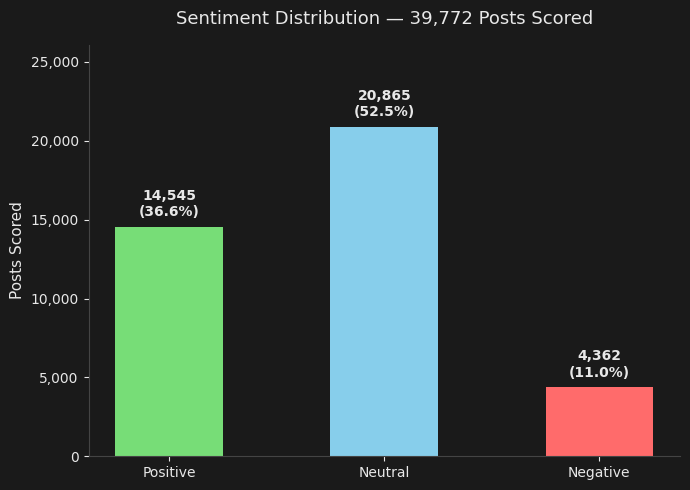

In [6]:
# Sentiment breakdown across all 270 assets
pos = df['sentiment_posts_pos'].sum()
neu = df['sentiment_posts_neu'].sum()
neg = df['sentiment_posts_neg'].sum()
total = pos + neu + neg

labels = ['Positive', 'Neutral', 'Negative']
counts = [pos, neu, neg]
pcts = [x/total*100 for x in counts]
colors = ['#77dd77', '#87ceeb', '#ff6b6b']

fig, ax = plt.subplots(figsize=(7, 5))
fig.patch.set_facecolor('#1a1a1a')
ax.set_facecolor('#1a1a1a')

bars = ax.bar(labels, counts, color=colors, width=0.5, edgecolor='none')

for bar, pct, count in zip(bars, pcts, counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500,
            f'{count:,}\n({pct:.1f}%)', ha='center', va='bottom',
            color='#e8e8e8', fontsize=10, fontweight='bold')

ax.set_ylabel('Posts Scored', color='#e8e8e8', fontsize=11)
ax.set_title(f'Sentiment Distribution — {total:,} Posts Scored',
             color='#e8e8e8', fontsize=13, pad=15)
ax.set_ylim(0, max(counts) * 1.25)
ax.tick_params(colors='#e8e8e8')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#444')
ax.spines['bottom'].set_color('#444')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
plt.tight_layout()
plt.show()

## 5. Most Discussed Assets

Which assets had the most X (Twitter) activity in this sample?

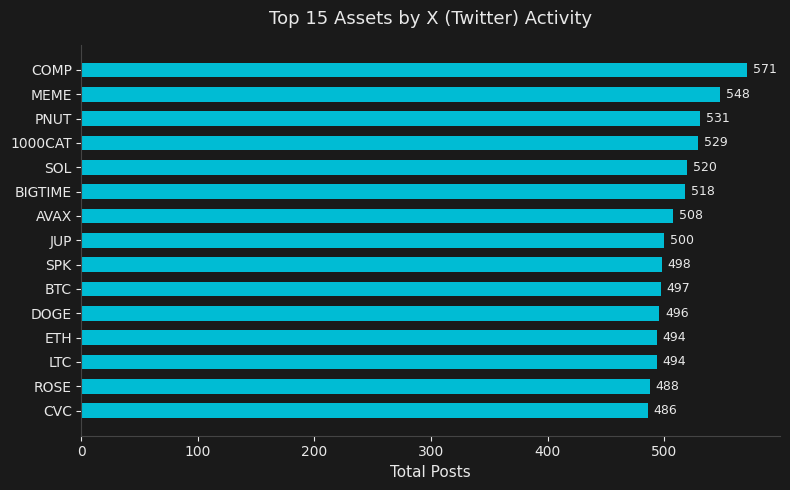

In [7]:
top = (df.groupby('symbol')['sentiment_posts_total']
       .sum()
       .nlargest(15)
       .sort_values())

fig, ax = plt.subplots(figsize=(8, 5), facecolor='#1a1a1a')
ax.set_facecolor('#1a1a1a')
ax.barh(top.index, top.values, color='#00bcd4', height=0.6)

for i, (sym, val) in enumerate(top.items()):
    ax.text(val + 5, i, f'{val:,}', va='center', color='#e8e8e8', fontsize=9)

ax.set_xlabel('Total Posts', color='#e8e8e8', fontsize=11)
ax.set_title('Top 15 Assets by X (Twitter) Activity', color='#e8e8e8', fontsize=13, pad=15)
ax.tick_params(colors='#e8e8e8')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#444')
ax.spines['bottom'].set_color('#444')
plt.tight_layout()
plt.show()

## 6. Sentiment vs Liquidity

Do well-discussed assets tend to have better liquidity? Plotting sentiment post count against the global liquidity percentile.

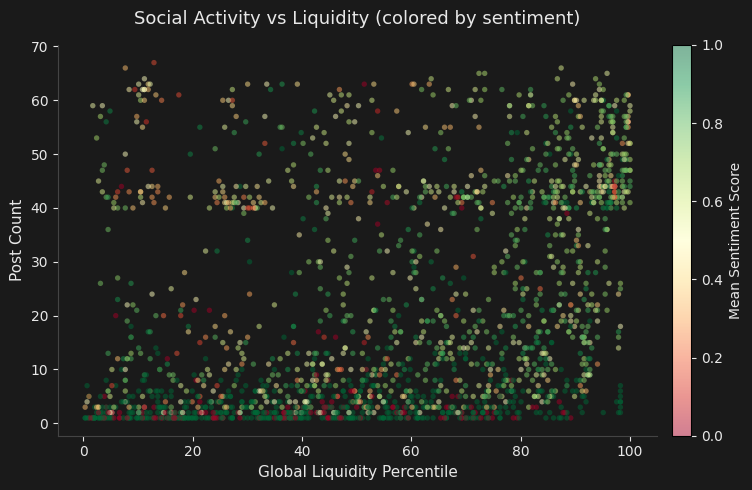

In [8]:
active = df[df['sentiment_posts_total'] > 0].copy()

fig, ax = plt.subplots(figsize=(8, 5), facecolor='#1a1a1a')
ax.set_facecolor('#1a1a1a')

scatter = ax.scatter(
    active['derived_liq_global_pct'],
    active['sentiment_posts_total'],
    c=active['sentiment_mean_score'],
    cmap='RdYlGn', vmin=0, vmax=1,
    s=15, alpha=0.5, edgecolors='none'
)

cbar = plt.colorbar(scatter, ax=ax, pad=0.02)
cbar.set_label('Mean Sentiment Score', color='#e8e8e8', fontsize=10)
cbar.ax.tick_params(colors='#e8e8e8')

ax.set_xlabel('Global Liquidity Percentile', color='#e8e8e8', fontsize=11)
ax.set_ylabel('Post Count', color='#e8e8e8', fontsize=11)
ax.set_title('Social Activity vs Liquidity (colored by sentiment)',
             color='#e8e8e8', fontsize=13, pad=15)
ax.tick_params(colors='#e8e8e8')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#444')
ax.spines['bottom'].set_color('#444')
plt.tight_layout()
plt.show()

## 7. Spread Distribution

Bid-ask spreads in basis points — how tight are execution costs across the tracked universe?

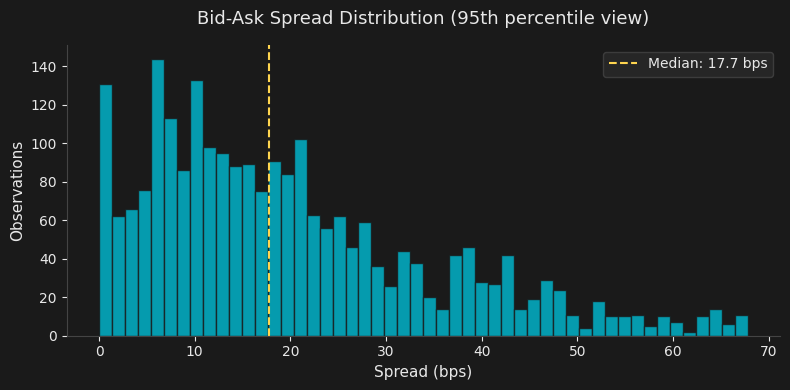

In [9]:
spreads = df['spot_spread_bps'].dropna()
spreads_capped = spreads[spreads < spreads.quantile(0.95)]  # remove extreme outliers for display

fig, ax = plt.subplots(figsize=(8, 4), facecolor='#1a1a1a')
ax.set_facecolor('#1a1a1a')
ax.hist(spreads_capped, bins=50, color='#00bcd4', alpha=0.8, edgecolor='#1a1a1a')

ax.axvline(spreads.median(), color='#ffd54f', linestyle='--', linewidth=1.5,
           label=f'Median: {spreads.median():.1f} bps')
ax.legend(facecolor='#2a2a2a', edgecolor='#444', labelcolor='#e8e8e8')

ax.set_xlabel('Spread (bps)', color='#e8e8e8', fontsize=11)
ax.set_ylabel('Observations', color='#e8e8e8', fontsize=11)
ax.set_title('Bid-Ask Spread Distribution (95th percentile view)',
             color='#e8e8e8', fontsize=13, pad=15)
ax.tick_params(colors='#e8e8e8')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#444')
ax.spines['bottom'].set_color('#444')
plt.tight_layout()
plt.show()

---
## What You’ve Seen

This notebook demonstrates **Tier 1 (Explorer)** — the simplest Instrumetriq dataset.

**Tier 1 — Explorer ($8/month)**  
- 19 flat columns  
- Aggregated sentiment counts and averages  
- Spot price, spread, liquidity, and quality scores  
- One row per monitored asset session  

Higher tiers extend the same observations:

- **Tier 2 — Analyst ($18/month)**  
  Adds nested sentiment detail, author and engagement aggregates, and richer market structure metrics.

- **Tier 3 — Researcher ($38/month)**  
  Adds futures data, multi-window sentiment, 700+ price samples per session, and diagnostic metadata.

Links:
- Free samples: https://github.com/SiCkGFX/instrumetriq-public  
- Access & tiers: https://instrumetriq.com/access  
- Methodology: https://instrumetriq.com/research  

*Instrumetriq publishes observational datasets only.  
No trading advice, predictions, or signal generation.*
---
